# Projeto Questão 1 - Aprendizagem de Máquina - Pós Graduação - 2022.2 - Prof. Francisco Carvalho

## Grupo
- Miguel Cruz (mlpcs@cin.ufpe.br)
- Lucas Augusto (lama2@cin.ufpe.br)
- Marcela Cristina (mcp2@cin.ufpe.br)

In [115]:
import numpy as np
import os 
import pandas as pd
from datetime import datetime


Valores importantes

K = numero de clusters \\
p = numero de matrizes de dissimilaridade \\
n = numero de exemplos


#Dimensionalidades:
 - G = p x K  
 - U = K x N  
 - A = p x K
-  D = p x n x n 

term_1  = K x n
term_2  = x 

# Loading

In [116]:
store = pd.HDFStore("diss_matrices_.h5")

In [ ]:
%%time
D_ = [np.expand_dims(store[matrix].to_numpy(), axis=0) for matrix in store]
D_ = np.concatenate(D_,axis=0)
print(D_.shape)


In [ ]:
store.close()

In [ ]:
D_.shape

(3, 20867, 20867)

# Techiniques

In [ ]:
def select_medoids_dist(D,G):
    result = np.stack([D[i,G[i],:] for i in range(D.shape[0])], axis=0 )
    return result


In [ ]:
def compute_J(G,U,D,A,m=2):
    Dt = select_medoids_dist(D,G)
    Ut = np.power(U,m)
    At  = np.einsum('pk,pkn->kn',A,Dt) 
    return np.einsum('kn,kn->',At,Ut)

In [ ]:
def search_best_medoids(G,U,D,A,m):

    all = []
    for p in range (D.shape[0]):
        al = []
        for k in range(U.shape[0]):
            h = np.sum(np.power(U[k],m)*D[p,:,:],axis=1).argmin()
            al.append(h)
        all.append(al)
    
    g = np.asarray(all)
    
    return g


In [ ]:
def compute_U_fuzzy_part(G, U, D, A, m):
    Dk = select_medoids_dist(D,G)
    
    term_1  = np.einsum('pk,pkn->kn',A,Dk)
    term_2 = term_1
    term_1[np.where(term_1 == 0)] = 1


    term_1  = np.power(term_1,-1/(m-1))
    term_2  = np.power(term_2,-1/(m-1))
    term_2  = np.einsum('kn->n',term_2)
    Ut = np.divide(term_1, term_2)
    return Ut

In [ ]:
def search_best_relev_vec(G,U,D,A,m):
    Dt = select_medoids_dist(D,G)

    Ut = np.power(U,m)
    l = np.einsum('kn,pkn->pk',Ut,Dt)

    a  = np.prod(l,axis=0)
    a  = np.power(a,(1/(D.shape[0])))
    al = np.divide(a,l)
    
    return al

# Experiments

In [ ]:
def mv_algorithm(D, K, m, T, e, seed = 87, verbose=False):

    """
    
    """

    ########## CONSTRAINTS ##############
     
    assert D.shape[1] == D.shape[2]
    assert K > 1 and K < D.shape[1]
    assert e > 0 
    #assert m > 1
    if m <= 1:
        m = 1.0001

    ######### INITIALIZATION #############

    p = D.shape[0]
    n = D.shape[1]
  
    rng        = np.random.default_rng(seed=seed)
    G          = np.stack([rng.choice(n,size=(K),replace=False) for _ in range(p)],axis=0)
    A          = np.ones(shape=(p,K))
    U          = compute_U_fuzzy_part(G,None,D,A,m)
   
    cur_u  = compute_J(G,U,D,A,m)
    last_u = 0

    ########## TRAINING LOOP ###############
    for t in range(T):
        
        G = search_best_medoids(G,U,D,A,m)
        A = search_best_relev_vec(G,U,D,A,m)
        U = compute_U_fuzzy_part(G,U,D,A,m)
        
        if(verbose):
            print("Epoch {} ---- ".format(t))
            print("Cur j = "+str(cur_u))

        last_u = cur_u
        cur_u = compute_J(G,U,D,A,m)

        if(verbose):
            print("dif = {}".format(np.absolute(cur_u-last_u)))
            
        if np.absolute(cur_u-last_u) < e   or  t => T-1: 
            print("Converged with J = {}".format(np.absolute(cur_u)))
            print("dif = {}".format(np.absolute(cur_u-last_u)))
            print('Converged in {} iterations'.format(t+1))
            return G,U,D,A, cur_u, (t+1)

In [ ]:
def run_experiments(D_,K=12,T=150,e=1e-10,runs=1):

    now = datetime.now()
    time = now.strftime("%m_%d_%Y, %H_%M:%S")
    output_path = os.path.join(
    '../out/log_{}.csv'.format(time))


    f = open(output_path, 'w')
    f.write("seed,m,t,final_j\n")

    param = dict()
    best_model = 9999999
    seeds = np.random.randint(0,99999,runs,seed=87)
    
    
    for  seed in seeds:
        #m = np.random.lognormal(1.5, 1/16,seed=seed)
        m = 1.6
        print("============================")
        print("seed number {}".format(seed))
        print("m value {}".format(m))

        G,U,_,A,cur_u,t = mv_algorithm(D_, K, m, T, e, seed)

        f.write("{},{},{},{}\n".format(seed,m,t,cur_u))

        if cur_u < best_model:
            best_model = cur_u
            param['G'] = G
            param['U'] = U
            param['A'] = A
            param['m'] = m
            param['ob'] = cur_u
            param['t'] = t
            
    f.close()
    return param

In [ ]:
param =  run_experiments(D_,K=12,T=150,e=1e-10,runs=50)


In [ ]:
if True:
    store = pd.HDFStore("best_model_16.h5")
    store['G']  =   pd.DataFrame(param['G'])
    store['U']  =   pd.DataFrame(param['U'])
    store['A']  =   pd.DataFrame(param['A'])
    store['m']  =   pd.DataFrame([param['m']])
    store['ob'] =   pd.DataFrame([param['ob']])
    store['t']  =   pd.DataFrame([param['t']])
    store.close()


# Análise


In [ ]:
import matplotlib.pyplot as plt
import collections

In [ ]:
store = pd.HDFStore("best_model_16.h5")

G = np.asarray(store['G']).T
A_ = (np.asarray(store['A']))
U  = np.asanyarray(store['U'])
A = A_.argmax(axis=0)
store.close()

print("Prototipos: \n {}".format(G))
print("Pesos de relevancia: \n {}".format(A_.T))

#### MAPEANDO CADA ITEM PARA UM CLUSTER ###
cluster = (((np.asarray(U).argmax(axis=0))))


Prototipos: 
 [[ 9677  2185  8526]
 [ 5364 20481 20731]
 [16169  2185 19808]
 [16169  2185 19808]
 [14210  2185 19808]
 [ 9677  2185 19808]
 [16169  2185 19808]
 [16169  9503 19808]
 [16169  2185 19808]
 [16169  9503 19808]
 [14210  5462  8447]
 [16169  2185 19808]]
Pesos de relevancia: 
 [[1.0008275  1.00001178 0.99916141]
 [0.99926379 1.00213681 0.99860293]
 [1.00121984 0.99948786 0.99929342]
 [1.00121988 0.99948782 0.99929342]
 [0.9975696  1.00259767 0.99983906]
 [1.00030795 1.00027596 0.99941634]
 [1.00122043 0.99948734 0.99929335]
 [1.00293616 0.99784089 0.99922989]
 [1.00121985 0.99948785 0.99929342]
 [1.00293604 0.99784098 0.99922991]
 [0.99963825 1.00219501 0.99817088]
 [1.00121987 0.99948784 0.99929342]]


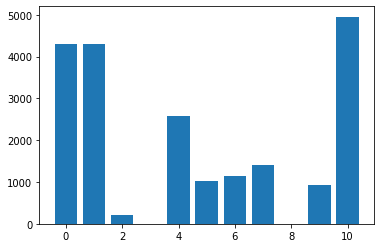

Counter({10: 4953, 1: 4309, 0: 4302, 4: 2583, 7: 1406, 6: 1150, 5: 1014, 9: 932, 2: 218})


In [ ]:

dist = collections.Counter(cluster)
plt.bar(dist.keys(), dist.values())
plt.show()
print(dist)

In [ ]:
input_path = os.path.join(
    '../data/generated', 'avila-combined.csv')

data = pd.read_csv(input_path)['10'] 
labels_gt = data.values.tolist()

## Calculo de métricas e display

In [ ]:


def compute_metrics(labels_gt,labels_pred):
    from sklearn.metrics import rand_score
    from sklearn.metrics import f1_score    

    def pc(U):
        """
        Returns the Partition Coefficient of the given clusters

            Parameters:
                U (np.ndarray): A n-dimensional vector of membership degree vectors (n x k)

            Returns:
                part_coeff (float): The Partition Coefficient
        """

        part_coeff = 0

        for ui in U:
            part_coeff += sum([uik**2 for uik in ui])

        N = U.shape[0]
        part_coeff /= N

        return part_coeff


    def mpc(U):
        """
        Returns the Modified Partition Coefficient of the given clusters

            Parameters:
                U (np.ndarray): A n-dimensional vector of membership degree vectors

            Returns:
                m_part_coeff (float): The Modified Partition Coefficient
        """

        part_coeff = pc(U)

        K = U.shape[1]

        m_part_coeff = 1 - (K / (K - 1)) * (1 - part_coeff)

        return m_part_coeff


    def pe(U):
        """
        Returns the Partition Entropy of the given clusters

            Parameters:
                U (np.ndarray): A n-dimensional vector of membership degree vectors

            Returns:
                part_entropy (float): The Partition Entropy
        """

        part_entropy = 0
        for ui in U:
            part_entropy += sum([uik * np.log(uik) for uik in ui])

        N = U.shape[0]
        part_entropy /= -N

        return part_entropy

    rd = rand_score(labels_gt,labels_pred)
    f1 = f1_score(labels_gt,labels_pred,average='macro')
    mpc_ = mpc(U.T)
    pe_ = pe(U.T)

    print("MPC = {}".format(mpc_))
    print("PE = {}".format(pe_))
    print("Rand Score = {}".format(rd))
    print("F measure = {}".format(f1))




In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_and_display(labels_gt,labels_pred):
    labels_gt_ = ['A','B','C','D','E','F','G','H','I','X','Y','W']
    compute_metrics(labels_gt,labels_pred)
    cm = confusion_matrix(labels_gt, labels_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels_gt_)
    disp.plot()
    plt.show()



### Partição Crisp que contenha todas as classes

In [ ]:
def crisp_all_classes(G,A,data,cluster,U):
    def all_classes(U, y):
        y = np.asarray(y)
        classes = np.unique(y.ravel())
        classes_to_groups = {}
        for c in classes:
            groups_to_class_representativeness = {g: np.sum(U[(np.array(y.ravel()) == c), g], axis=0) for g in range(U.shape[1]) if g not in classes_to_groups.values()}
            classes_to_groups[c] = max(groups_to_class_representativeness.keys(), key=lambda k: groups_to_class_representativeness[k])
        return {v: k for k, v in classes_to_groups.items()}
        
    data_list = all_classes(U.T,data)
    labels_pred = [data_list[idx] for idx in cluster ]
    return labels_pred
    

MPC = 0.000151762650465459
PE = 2.484069545039699
Rand Score = 0.6825762957265219
F measure = 0.0525654038005741


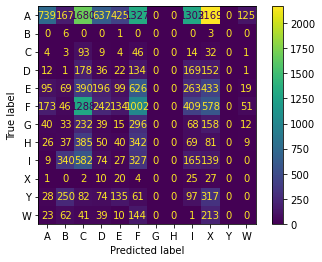

In [ ]:
labels_pred = crisp_all_classes(G,A,data,cluster,U)
compute_and_display(labels_gt,labels_pred)

### Partição Crisp Usando Voto Majoritário como critério

In [ ]:
def crisp_by_vote(G,A,data,cluster):
    from collections import Counter
 
    def most_frequent(List):
        occurence_count = Counter(List)
        return occurence_count.most_common(1)[0][0]

    data_list = []    
    ##### MAPEANDO O PROTOTIPO PARA LABEL ###
    for g in G:
        data_list.append([data.iloc[p] for p in g ])

    
    ### MAPEANDO PARA LABEL ###
    labels_pred = [data_list[idx] for idx in cluster ]
    labels_pred = [most_frequent(x) for x in labels_pred]

    return labels_pred

MPC = 0.000151762650465459
PE = 2.484069545039699
Rand Score = 0.4240054189558017
F measure = 0.06833682537877865


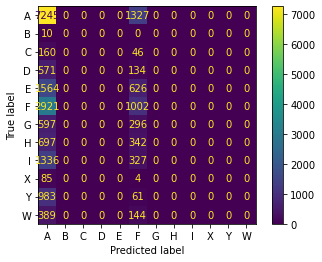

In [ ]:
labels_pred = crisp_by_vote(G,A,data,cluster)
compute_and_display(labels_gt,labels_pred)

### Partição Crisp Usando Lambda como critério

In [ ]:
def crisp_by_lambda(G,A,data,cluster):
    data_dict = dict()
    z  = []
    
    ##  SELECIONANDO O ELEMENTO REPRESENTATIVO DE CADA CLASSE #### 
    for i,index in enumerate(A):
        z.append(G[i][A[i]])
    z = np.asarray(z)

    ##### MAPEANDO O PROTOTIPO PARA LABEL ###
    for idx in range(len(z)):
        data_dict[idx] = data.iloc[z[idx]]

    
    ### MAPEANDO PARA LABEL ###
    labels_pred = [data_dict[idx] for idx in cluster ]

    return labels_pred


MPC = 0.000151762650465459
PE = 2.484069545039699
Rand Score = 0.4985521375029121
F measure = 0.06890185507101272


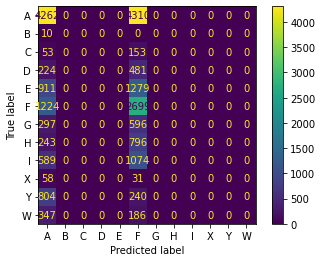

In [ ]:
labels_pred = crisp_by_lambda(G,A,data,cluster)
compute_and_display(labels_gt,labels_pred)
